# Imported Libraries

In [1]:
import DataExplorer as De
import DataPreprocessor as Dp
import ModelActivator as Ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm

# Read Data

In [2]:
stocks_by_id = pd.read_csv(
'C:/Users/manor/Desktop/Final Project - Algotrading/First Developement Step/Database/stocks_by_id.csv',
names=['id',
       'stock'
      ],
header=None)

In [3]:
end_of_day_prices = pd.read_csv(
        'C:/Users/manor/Desktop/Final Project - Algotrading/First Developement Step/Database/end_of_day_prices.csv',
        names=['id',
               'date',
               'close_price'],
header=None)

# Exploratory Data Analysis

## IDs of all stocks

In [4]:
stocks_by_id

,id,stock
0,1,MMM
1,2,AOS
2,3,ABT
3,4,ABBV
4,5,ABMD
...,...,...
498,499,YUM
499,500,ZBRA
500,501,ZBH
501,502,ZION


## Closing price by stock id and date

In [5]:
end_of_day_prices

,id,date,close_price
1,1,2012-01-03,83.49
2,1,2012-01-04,84.18
3,1,2012-01-05,83.80
4,1,2012-01-06,83.37
5,1,2012-01-09,83.87
...,...,...,...
1322251,503,2022-11-21,147.33
1322252,503,2022-11-22,148.63
1322253,503,2022-11-23,150.47
1322254,503,2022-11-25,150.10


## We chose to use 'MMM' stock id: 1

In [6]:
mmm_stock_data = end_of_day_prices.loc[end_of_day_prices.id == 1].copy()

## Exploratory Data Analysis

Stock Data

In [7]:
mmm_stock_data

,id,date,close_price
1,1,2012-01-03,83.49
2,1,2012-01-04,84.18
3,1,2012-01-05,83.80
4,1,2012-01-06,83.37
5,1,2012-01-09,83.87
...,...,...,...
2741,1,2022-11-21,127.63
2742,1,2022-11-22,128.60
2743,1,2022-11-23,128.00
2744,1,2022-11-25,129.04


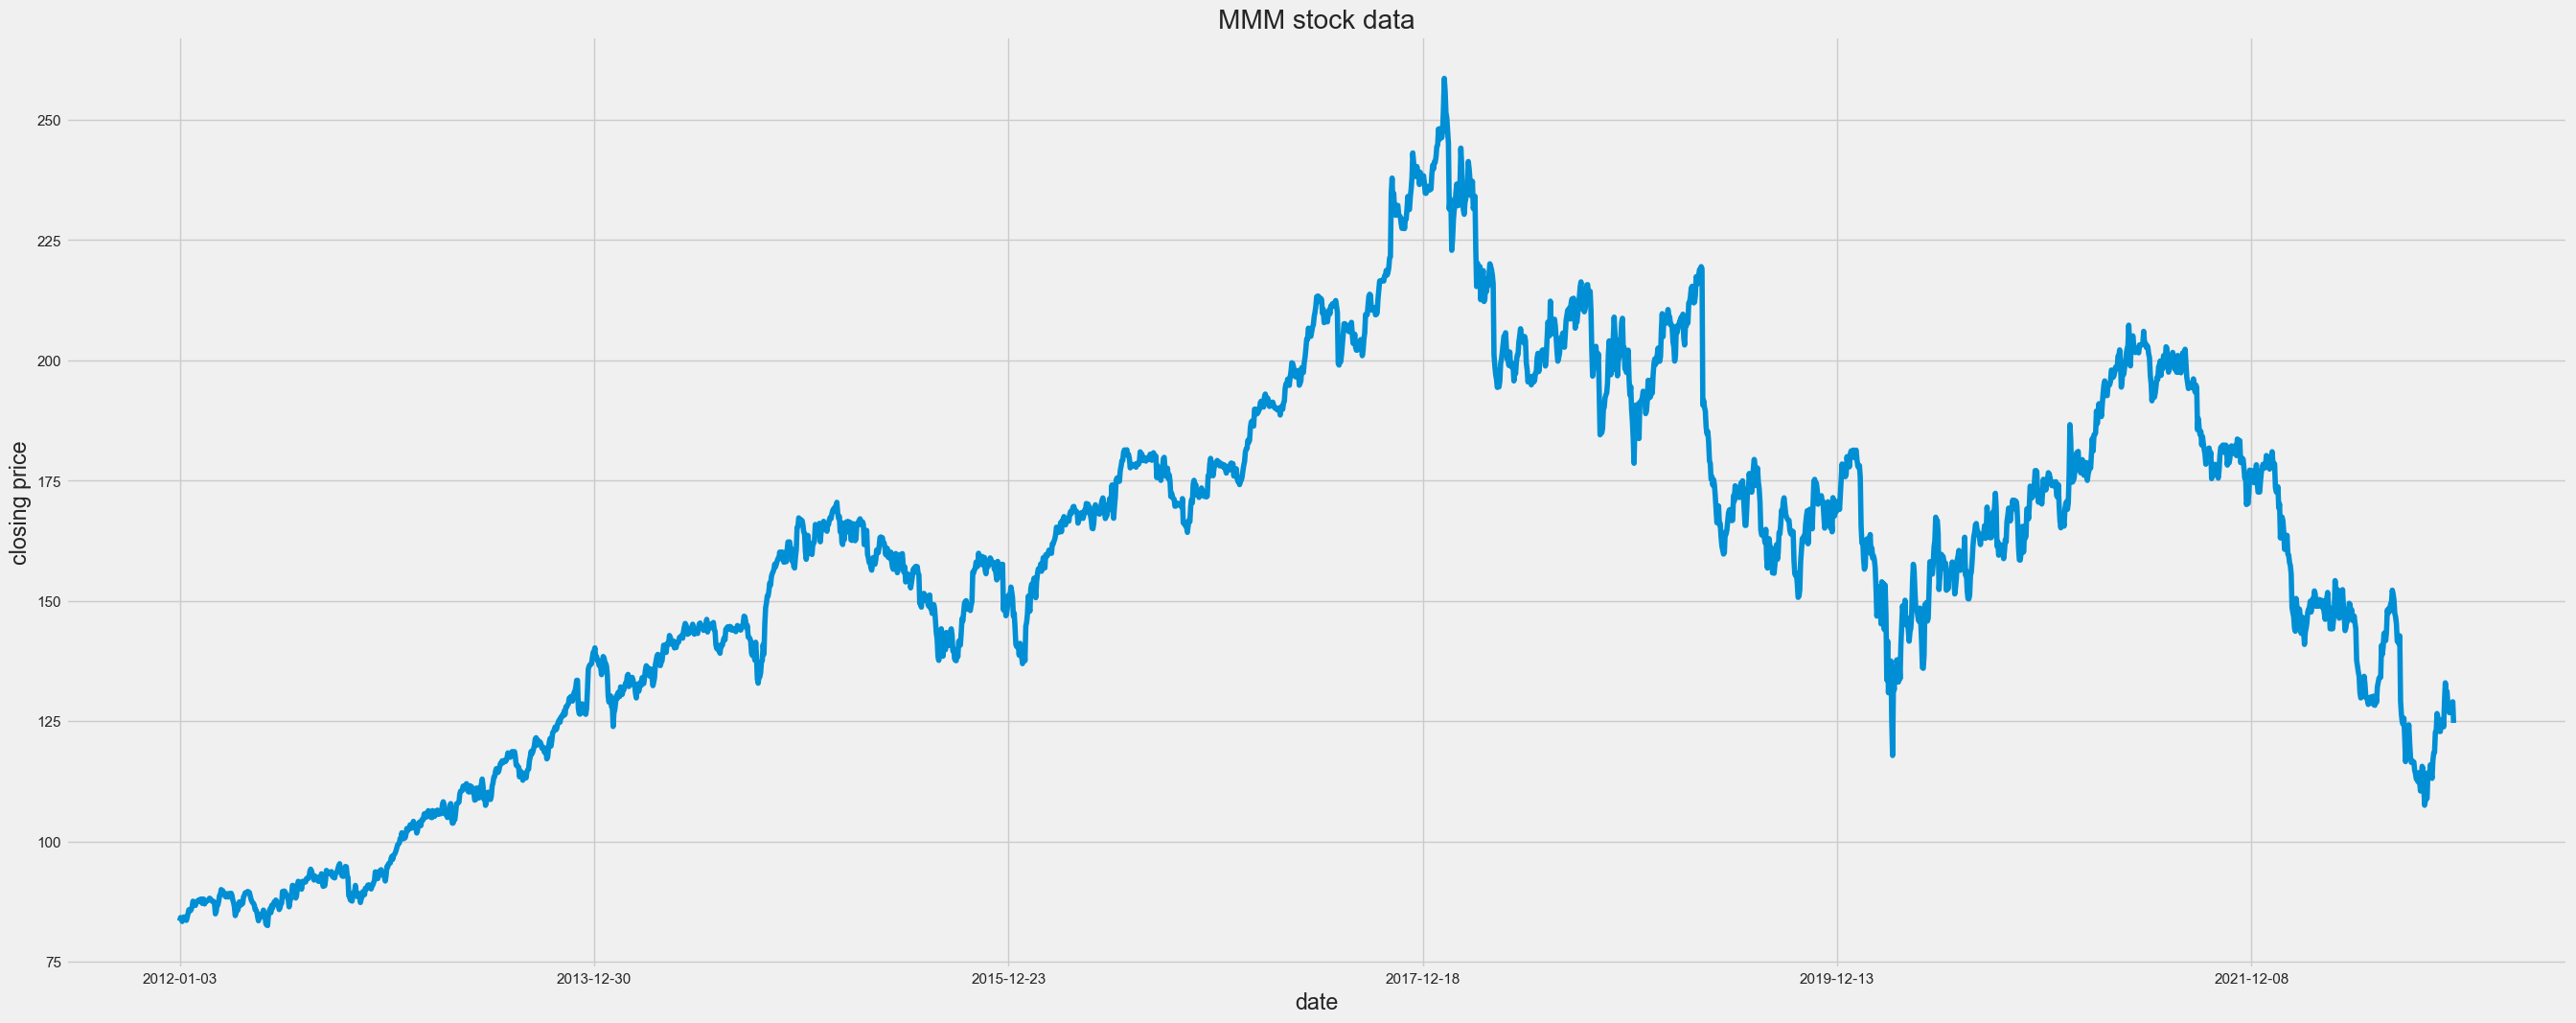

In [8]:
sns.set()
plt.style.use('fivethirtyeight')
mmm_stock_data.plot(x='date', y='close_price', figsize=(30, 12), legend=False)
plt.xlabel('date')
plt.ylabel('closing price')
plt.title('MMM stock data')
plt.show()

Some of the dates were missing, we filled them using the average of the past 2 days prior to the missing date

In [9]:
EDA = De.DataExplorer()

# count number of NaN values
nan_count = EDA.count_nan_values(mmm_stock_data)
print("Number of NaN values in the table: ", nan_count)

Number of NaN values in the table:  0


In [10]:
# results of the missing_dates_detection function:
gap_sizes_table, date_gaps, missing_dates = EDA.missing_dates_detection(mmm_stock_data)

gap_sizes_table

,Gap Size
0,4
1,3
2,3
3,3
4,3
...,...
2739,0
2740,0
2741,0
2742,0


Text(0, 0.5, 'Number Of Gaps')

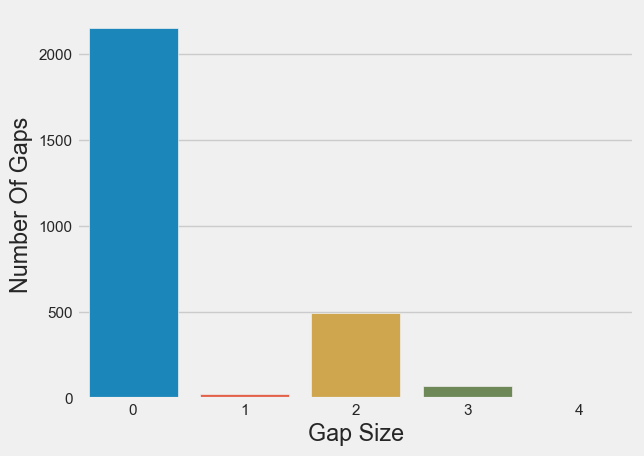

In [11]:
number_of_gaps = pd.value_counts(gap_sizes_table['Gap Size']).values
gap_sizes = pd.value_counts(gap_sizes_table['Gap Size']).keys()

sns.barplot(x = gap_sizes, y = number_of_gaps)
plt.ylabel(ylabel='Number Of Gaps')

In [12]:
percentage_of_missing = ((missing_dates/(missing_dates + mmm_stock_data.shape[0])) * 100)

print("Number of missing dates: ", missing_dates)
print(f'Percentage of missing dates: {percentage_of_missing}%')

Number of missing dates:  1238
Percentage of missing dates: 31.08209892041175%


# Preprocessing

In [ ]:
mmm_stock_data['date']

In [ ]:
preprocess = Dp.DataPreprocessor()

### Best Imputation Method
Some of the dates were missing. We wished to find the best filling method for them. We trained a model in order to do so. The best filling method was chosen based on the lowest MSE: 

In [ ]:
rf_starting_params = {'n_estimators': 100, 'oob_score': True, 'random_state': 0}

imputations_df = pd.DataFrame(columns=['Imputation Method', 'Dataset MSE'])

methods_list = [1, 2, 4]

for method in methods_list:
    
    #Fill each stock data with missing dates-prices by different method:price of the recent date/mean of prices of last 2
    # dates/mean of prices of last 4 dates
    raw_and_missing, missing = preprocess.add_missing_dates(mmm_stock_data, method)
    
    #Drop id column, set 'date' column as index and convert it to 'datetime' data type.
    # This is done on the unified data, composed of the original dates-prices and artificially filled dates-prices
    preprocess.alter_table(raw_and_missing, 'date', 'id')
    
    #create label column
    raw_and_missing['tomorrow'] = raw_and_missing['close_price'].shift(-1)
    
    #split to X and y. Remove last row (its label is nan):
    X, y = preprocess.rmv_nans_splt_Xy(raw_and_missing, 'tomorrow')
    
    #train random forest with starting parameters:
    regr = RandomForestRegressor(**rf_starting_params)
    
    regr.fit(X, y)
    
    y_preds = regr.predict(X)
    
    stock_dataset_mse = mean_squared_error(y.values, y_preds)
    
    imputations_df.loc[len(imputations_df)] = pd.Series({'Imputation Method': method,
                                                         'Dataset MSE': stock_dataset_mse
                                                         })
    

best_stock_dataset_mse = imputations_df['Dataset MSE'].min()
    
best_row = imputations_df[imputations_df['Dataset MSE'] == best_stock_dataset_mse]

best_row

In [ ]:
#fill in missing dates by best method
best_method_number = best_row['Imputation Method'].iloc[0]
raw_and_missing, missing = preprocess.add_missing_dates(mmm_stock_data, best_method_number)

In [ ]:
#for the raw data, the unified raw and for the missing data, remove stock id column,
#set 'date' column as index and convert 'date' column to 'datetime' data type:
preprocess.alter_table(mmm_stock_data, 'date', 'id')
preprocess.alter_table(raw_and_missing, 'date', 'id')
preprocess.alter_table(missing, 'date', 'id')

### Best Number Of Lookback Features
We trained the model with the same starting parameters in order to find the best number of lookback features (from 1 to 15).
The data was temporally split to train (80%) and test (20%).<br>The best number of lookback features was chosen based on the lowest train MSE score. 

In [ ]:
# running random forest on multiple options of 'days before'(= n):

days_before_list = list(range(1, 16))

days_before_df = pd.DataFrame(columns=['days before', 'train MSE', 'test MSE'])

# find the best 'n' number of days before based on lowest train mse
for n in tqdm(days_before_list, desc='lookback days'):
    
    # create n lookback features
    raw_and_missing_new = preprocess.create_features(raw_and_missing, n, 'close_price', '_days_ago', 'tomorrow')
    
    # drop all missing dates - since we want to prevent our model from learning the relations between each closing price
    raw_and_missing_new =  preprocess.drop_missing_dates(raw_and_missing_new, missing)

    ## Temporal splitting to train and test:
    split_date = preprocess.generate_split_date(raw_and_missing_new) # train size was set to 0.8 of data size

    train = raw_and_missing_new.iloc[raw_and_missing_new.index <= split_date].copy()
    test = raw_and_missing_new.loc[raw_and_missing_new.index > split_date].copy()

    # remove rows and split the data to X and y:
    X_train, y_train = preprocess.rmv_nans_splt_Xy(train, 'tomorrow')
    X_test, y_test = preprocess.rmv_nans_splt_Xy(test, 'tomorrow')
    
    #train random forest with starting parameters:
    regr = RandomForestRegressor(**rf_starting_params)
    
    regr.fit(X_train, y_train)
    
    y_train_preds = regr.predict(X_train)
    y_test_preds = regr.predict(X_test)
    
    X_train_mse = mean_squared_error(y_train.values, y_train_preds)
    X_test_mse = mean_squared_error(y_test.values, y_test_preds)
    
    days_before_df.loc[len(days_before_df)] = pd.Series({'days before': n,
                                                         'train MSE': X_train_mse,
                                                         'test MSE': X_test_mse
                                                         })
    
#calculate lowest train mse
best_lookback_mse = days_before_df['train MSE'].min()
        
#get the entire row with best train mse
best_row = days_before_df[days_before_df['train MSE'] == best_lookback_mse]

best_row

# Hyperparameter Tuning

Finding the best hyperparameter set based on the lowest test MSE

In [ ]:
# create best 'n' lookback features
best_n = int(best_row['days before'].iloc[0])
raw_and_missing_new = preprocess.create_features(raw_and_missing, best_n, 'close_price', '_days_ago', 'tomorrow')

In [ ]:
# drop all missing dates - since we want to prevent our model from learning the relations between each closing price
raw_and_missing_new =  preprocess.drop_missing_dates(raw_and_missing_new, missing)

In [ ]:
## Temporal splitting to train and test:
split_date = preprocess.generate_split_date(raw_and_missing_new) # train size was set to 0.8 of data size

train = raw_and_missing_new.iloc[raw_and_missing_new.index <= split_date].copy()
test = raw_and_missing_new.loc[raw_and_missing_new.index > split_date].copy()

In [ ]:
# remove rows and split the data to X and y:
X_train, y_train = preprocess.rmv_nans_splt_Xy(train, 'tomorrow')
X_test, y_test = preprocess.rmv_nans_splt_Xy(test, 'tomorrow')

In [ ]:
# running random forest on all permutations of selected parameters:

activate_model = Ma.ModelActivator()

params_and_mse_df = pd.DataFrame(columns=['parameters set', 'train MSE', 'test MSE'])

rf_full_params = {'n_estimators': [50, 100, 200],  # The number of trees in the forest
                'max_depth': [None, 5, 7, 9], # The maximum depth of the tree.
                                            # If None, then nodes are expanded until all leaves are pure or until all leaves contain less   than min_samples_split samples
                'min_samples_split': [2, 10, 20, 30],
                'max_features': [1, 3, 5, 7],  # The number of features to consider when looking for the best split results
                'oob_score': [True, False],
                'random_state': [None, 0, 711] # The randomness of the bootstrapping of the samples used when building trees and                                the sampling of the features to consider when looking for the best split at each node
                }

all_rf_params_permutations = list(ParameterGrid(rf_full_params))
    
# find the best parameters with 15 additional lookback features based on lowest test mse
for params in tqdm(all_rf_params_permutations, desc="model params"):

# train model, return train mse and test mse
    train_mse, test_mse = activate_model.run_random_forest(X_train, y_train, X_test, y_test, params)
    
#add all trained combinations of parameters to a dataframe along with their train mse and test mse     
    params_and_mse_df.loc[len(params_and_mse_df)] = pd.Series({
                                                                        'parameters set': params,
                                                                        'train MSE': train_mse,
                                                                        'test MSE': test_mse
                                                                    })
#get best test mse, which is the lowest test mse
best_test_mse = params_and_mse_df['test MSE'].min()

#get the entire row with best test mse
best_row = params_and_mse_df[params_and_mse_df['test MSE'] == best_test_mse]

best_row

In [ ]:
best_params = best_row['parameters set'].iloc[0]
best_params

# Model Training On one stock data

In [ ]:
""" PREPROCESSING: remove rows and split the data to X and y. """
X_data, y_data = preprocess.rmv_nans_splt_Xy(raw_and_missing_new, 'tomorrow')

"""train model on data with best hyperparameter set"""
regr = RandomForestRegressor(**best_params)
    
regr.fit(X_data, y_data)

"""save trained model"""
joblib.dump(regr, "./rf_compressed.joblib", compress=3)

In [ ]:
"""
export last date+price of one stock to csv:
"""
stock_name = stocks_by_id.loc[stocks_by_id.loc[:,'id'] == 1].values[0][1]
last_date_price = raw_and_missing_new.iloc[-1,0]
last_date_df = pd.DataFrame(data=[[stock_name ,last_date_price]], columns=['stock ticker', 'close price'])
last_date_df.to_csv('./latest date one stock.csv', index=False)

# --------------------------------------------------------------------------------------------------------------------

In [ ]:
# running random forest on multiple options of 'days before'(= n):

activate_model = Ma.ModelActivator()

days_before_list = list(range(1, 16))

features_names_list = []

all_params_and_mse_df = pd.DataFrame(columns=['parameters set', 'feature importances', 'train mse', 'test mse'])

best_params_and_mse_df = pd.DataFrame(columns=['days before', 'feature importances', 'parameters set', 'train mse', 'test mse'])

rf_full_params = {'n_estimators': [50, 100, 200],  # The number of trees in the forest
                'max_depth': [None, 5, 7, 9], # The maximum depth of the tree.
                                            # If None, then nodes are expanded until all leaves are pure or until all leaves contain less   than min_samples_split samples
                'min_samples_split': [2, 10, 20, 30],
                'max_features': [1, 3, 5, 7],  # The number of features to consider when looking for the best split results
                'random_state': [None, 0, 711] # The randomness of the bootstrapping of the samples used when building trees and                                the sampling of the features to consider when looking for the best split at each node
                }

all_rf_params_permutations = list(ParameterGrid(rf_full_params))

for n in tqdm(days_before_list, desc='lookback days'):
    
    # create lookback features
    raw_and_missing_new = preprocess.create_features(raw_and_missing, n, 'close_price', '_days_ago', 'tomorrow')
    
    # drop all missing dates - since we want to prevent our model from learning the connections between each closing price
    raw_and_missing_new =  preprocess.drop_missing_dates(raw_and_missing_new, missing)

    ## Temporal splitting to train and test:
    split_date = preprocess.generate_split_date(raw_and_missing_new) # train size was set to 0.8 of data size

    train = raw_and_missing_new.iloc[raw_and_missing_new.index <= split_date].copy()
    test = raw_and_missing_new.loc[raw_and_missing_new.index > split_date].copy()

    # remove rows and split the data to X and y:
    X_train, y_train = preprocess.rmv_nans_splt_Xy(train, 'tomorrow')
    X_test, y_test = preprocess.rmv_nans_splt_Xy(test, 'tomorrow')
    
    # find best parameters for every 'n' number of days before based on lowest test mse
    for params in tqdm(all_rf_params_permutations, desc="model params"):
    
    # train model, return train mse, test mse and feature importances
        train_mse, test_mse, feature_importances = activate_model.run_random_forest(X_train, y_train, X_test, y_test, params)
        

    #add all trained combinations of parameters to a dataframe along with their train mse and test mse     
        all_params_and_mse_df.loc[len(all_params_and_mse_df)] = pd.Series({
                                                                            'parameters set':params,
                                                                            'feature importances':feature_importances,
                                                                            'train mse':train_mse,
                                                                            'test mse':test_mse
                                                                        })
    #get best test mse, which is the lowest test mse
    best_test_mse = all_params_and_mse_df['test mse'].min()
    
    #get the entire row with best test mse
    best_row = all_params_and_mse_df[all_params_and_mse_df['test mse'] == best_test_mse]
    
    #put the lookback days along with the best row in a dataframe 
    best_params_and_mse_df.loc[len(best_params_and_mse_df)] = pd.Series({
                                                                'days before':n,
                                                                'parameters set':best_row['parameters set'].values[0],
                                                                'feature importances':best_row['feature importances'].values,
                                                                'train mse':float(best_row['train mse'].values),
                                                                'test mse':float(best_row['test mse'].values)
                                                                })
    all_params_and_mse_df = pd.DataFrame(columns=['parameters set', 'feature importances', 'train mse', 'test mse'])
    features_names_list.append(X_test.columns)

In [ ]:
#results for 1, 3, 5, 7 lookback features
best_params_and_mse_df[['days before', 'train mse', 'test mse']]

In [ ]:
for i in range(len(days_before_list)):
    forest_importances_df = pd.DataFrame(best_params_and_mse_df['feature importances'][i][0], index=features_names_list[i])
    forest_importances_df.plot.bar(legend=False)

In [ ]:
for i in range(len(days_before_list)):
    forest_importances_df = pd.DataFrame(best_params_and_mse_df['feature importances'][i][0], index=features_names_list[i])
    forest_importances_df.plot.bar(legend=False)

In [ ]:
#results for 7, 17, 27 lookback features
best_params_and_mse_df[['days before', 'train mse', 'test mse']]